## Vehicle Detection Project
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

/Users/qingdi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 1. read in all the vehicle and non-vehicle images, and display the dataset info

In [3]:
vehicles = glob.glob('dataset/vehicles/**/*.png')
nonvehicles = glob.glob('dataset/non-vehicles/**/*.png')

# Define a function to return some characteristics of the dataset 
def data_look(vehicles, nonvehicles):
    data_dict = {}
    # Define a key in data_dict "n_vehicles" and store the number of vehicle images
    data_dict["n_vehicles"] = len(vehicles)
    # Define a key "n_nonvehicles" and store the number of non-vehicle images
    data_dict["n_nonvehicles"] = len(nonvehicles)
    # Read in a test image, either vehicles or nonvehicles
    # Define a key "image_shape" and store the test image shape 3-tuple
    example_img = mpimg.imread(vehicles[0])
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(vehicles, nonvehicles)

print('num. of vehicles:', data_info["n_vehicles"], ' num. of nonvehicles:', data_info["n_nonvehicles"])
print('image size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])

num. of vehicles: 8792  num. of nonvehicles: 8968
image size:  (64, 64, 3)  and data type: float32


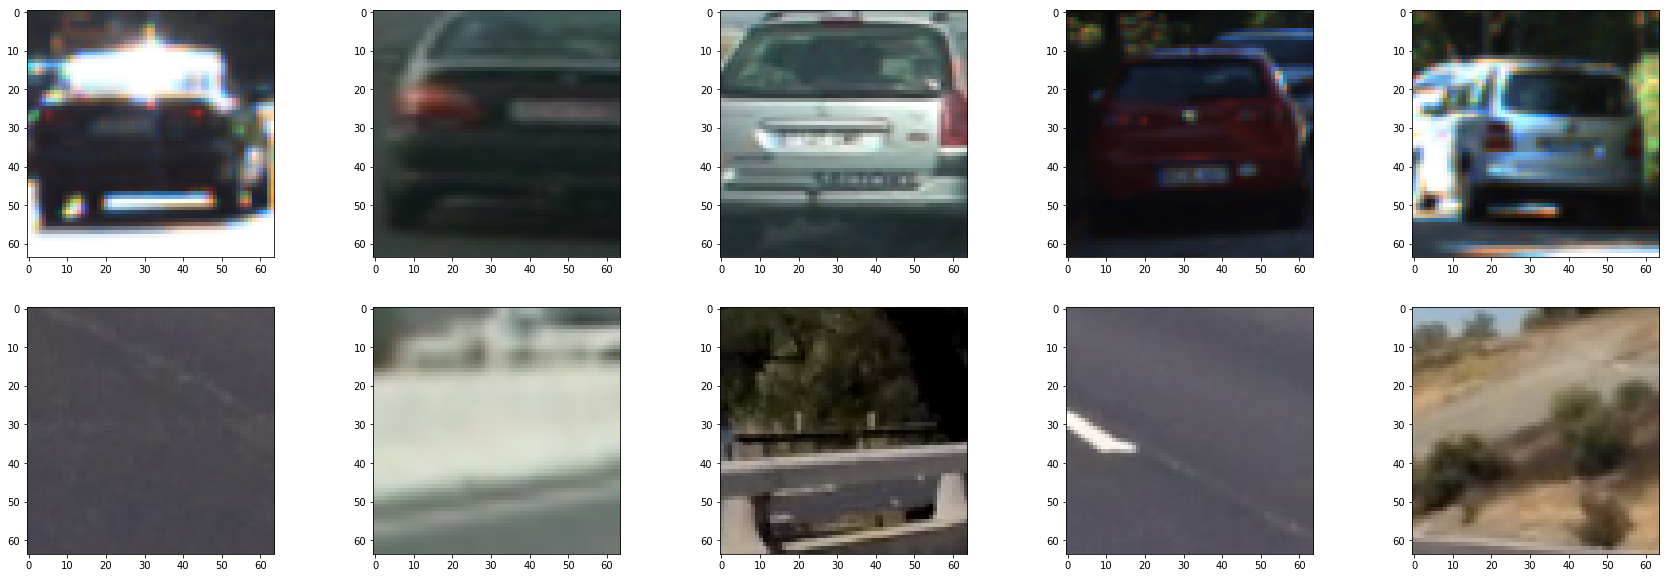

In [6]:
# random display 5 vehicle/non-vehicle images

%matplotlib inline

num = 5
fig, ax = plt.subplots(2, num, figsize=(30, 10))
ax = ax.ravel()
for i in range(num):
    v_ind = np.random.randint(0, len(vehicles))
    nv_ind = np.random.randint(0, len(nonvehicles))
    
    # Read in car / not-car images
    v_image = mpimg.imread(vehicles[v_ind])
    nv_image = mpimg.imread(nonvehicles[nv_ind])
    ax[i].imshow(v_image)
    ax[i+num].imshow(nv_image)

### 2. Define functions to extract HOG features from the training images.

In [25]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def convert_image(image, cspace='RGB'):
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    return feature_image
            
# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_image(image, cspace)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


/Users/qingdi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


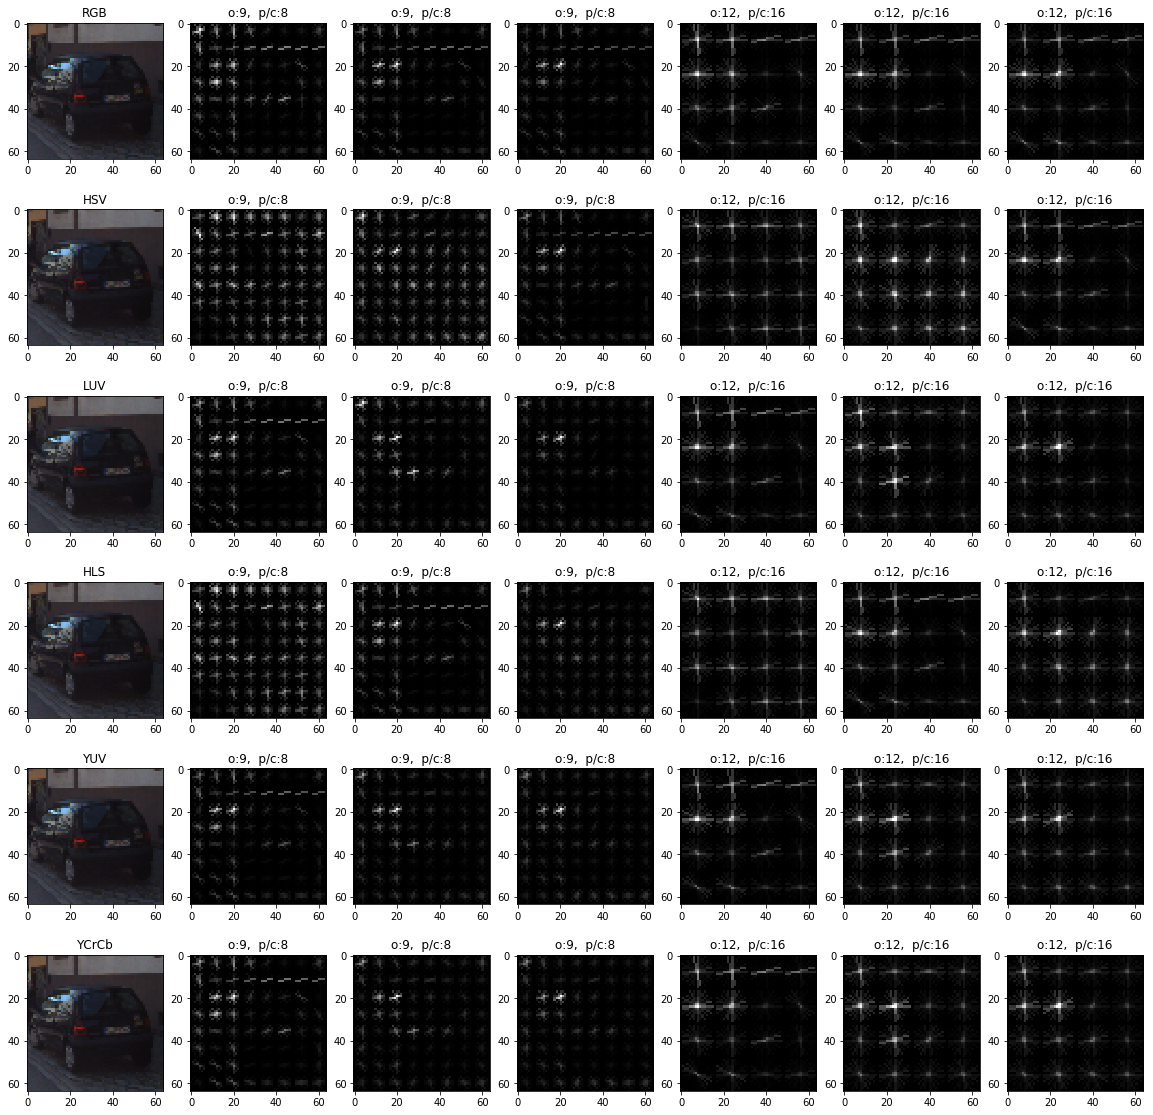

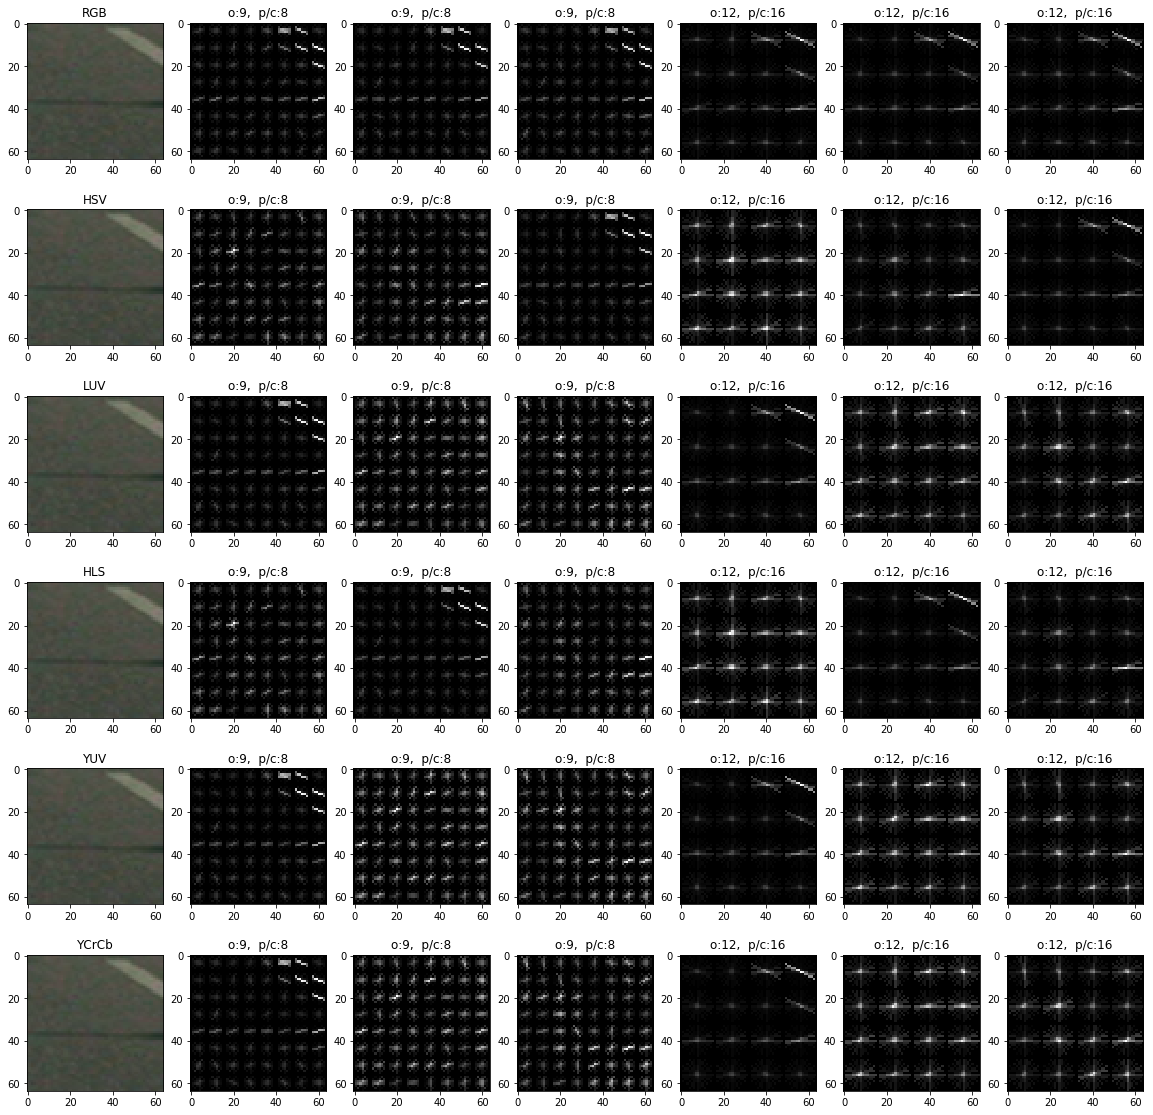

In [23]:
# Visualize the hog features in different color spaces

def vis_hog(image):
    cspaces = ['RGB','HSV','LUV','HLS','YUV','YCrCb']
    fig, ax = plt.subplots(len(cspaces),7, figsize=(20, 20))
    ax = ax.ravel()
    # HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`
    orient = [9, 12]
    pix_per_cell = [8, 16]
    cell_per_block = [2, 2]
    i = 0
    for c in cspaces:
        feature_image = convert_image(image, c)
        ax[i].imshow(image)
        ax[i].set_title(c)
        i=i+1
        for j in range(2):
            for channel in range(feature_image.shape[2]):
                features, hog_image = get_hog_features(feature_image[:,:,channel], 
                        orient[j], pix_per_cell[j], cell_per_block[j], 
                        vis=True, feature_vec=True)
                ax[i].imshow(hog_image, cmap='gray')
                ax[i].set_title("o:"+str(orient[j])+",  p/c:"+str(pix_per_cell[j]))
                i = i+1
                

v_ind = np.random.randint(0, len(vehicles))
nv_ind = np.random.randint(0, len(nonvehicles))

# Read in car / not-car images
v_image = mpimg.imread(vehicles[v_ind])
nv_image = mpimg.imread(nonvehicles[nv_ind])

vis_hog(v_image)
vis_hog(nv_image)


### 3. Explore various combinations of colorspaces, hog_channels, orientations, pixels_per_cell, and cells_per_block

In [27]:

def explore_param(colorspace, orient, pix_per_cell, cell_per_block, hog_channel):
    t1=time.time()
    vehicles_features = extract_features(vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    nonvehicles_features = extract_features(nonvehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    t2 = time.time()
    # Create an array stack of feature vectors
    X = np.vstack((vehicles_features, nonvehicles_features)).astype(np.float64)                        
    # Fit a per-column scaler
    # X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    # scaled_X = X_scaler.transform(X)
    # no need to scale for hog features only model
    scaled_X = X

    # Define the labels vector
    y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(nonvehicles_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)


    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t3=time.time()
    svc.fit(X_train, y_train)
    t4 = time.time()
    print(colorspace, orient, pix_per_cell, cell_per_block, hog_channel, 
          round((t2-t1), 2), round((t4-t3), 2), round(svc.score(X_test, y_test), 4))
    
### Check these parameters and see how the results change.
#colorspace = ['RGB','HSV','LUV','HLS','YUV','YCrCb']
#orient = [8]
#pix_per_cell = [8]
#cell_per_block = 2
#hog_channel = [0, 1, 2, "ALL"]
colorspace = ['HSV','YUV','YCrCb']
orient = [8,9,10]
pix_per_cell = [8, 16]
cell_per_block = 2
hog_channel = ["ALL"]

for c in colorspace:
    for o in orient:
        for p in pix_per_cell:
            for h in hog_channel:
                check_param(c, o, p, cell_per_block, h)


/Users/qingdi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


HSV 8 8 2 ALL 89.78 14.96 0.9786
HSV 8 16 2 ALL 60.31 2.54 0.9671
HSV 9 8 2 ALL 73.47 19.32 0.9814
HSV 9 16 2 ALL 61.08 3.3 0.9626
HSV 10 8 2 ALL 76.8 20.88 0.9873
HSV 10 16 2 ALL 62.07 2.37 0.9735
YUV 8 8 2 ALL 73.88 13.85 0.982
YUV 8 16 2 ALL 45.77 2.19 0.9707
YUV 9 8 2 ALL 73.17 16.77 0.9778
YUV 9 16 2 ALL 60.22 2.49 0.9738
YUV 10 8 2 ALL 73.3 14.08 0.9811
YUV 10 16 2 ALL 60.93 2.32 0.98
YCrCb 8 8 2 ALL 71.0 13.44 0.9783
YCrCb 8 16 2 ALL 43.67 2.34 0.9755
YCrCb 9 8 2 ALL 71.83 16.62 0.9797
YCrCb 9 16 2 ALL 44.52 2.54 0.9696
YCrCb 10 8 2 ALL 73.04 18.77 0.9789
YCrCb 10 16 2 ALL 61.75 2.23 0.9758


### 4. Train a classifier using the selected HOG features

In [28]:
# Define a function to train the linear SVM  
def train_clf(colorspace, orient, pix_per_cell, cell_per_block, hog_channel):
    vehicles_features = extract_features(vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    nonvehicles_features = extract_features(nonvehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    t2 = time.time()
    # Create an array stack of feature vectors
    X = np.vstack((vehicles_features, nonvehicles_features)).astype(np.float64)                        
    # Define the labels vector
    y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(nonvehicles_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t3=time.time()
    svc.fit(X_train, y_train)    

    return svc

### 5. Sliding Window Search

In [34]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, colorspace, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_image(img_tosearch, cspace=colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Scale features and make a prediction
            #test_features = X_scaler.transform(hog_features.reshape(1, -1))  
            test_features = hog_features.reshape(1, -1)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bbox_list
    


In [51]:
# Define functions to filter false positives and to combine overlapping bounding boxes.
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        bRadio=(bbox[1][0]-bbox[0][0])/(bbox[1][1]-bbox[0][1])
        if bRadio>0.33 and bRadio < 3:
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_boxes(img, boxes):
    for b in boxes:
        cv2.rectangle(img, b[0],b[1], (0,0,255), 6)
    return img;

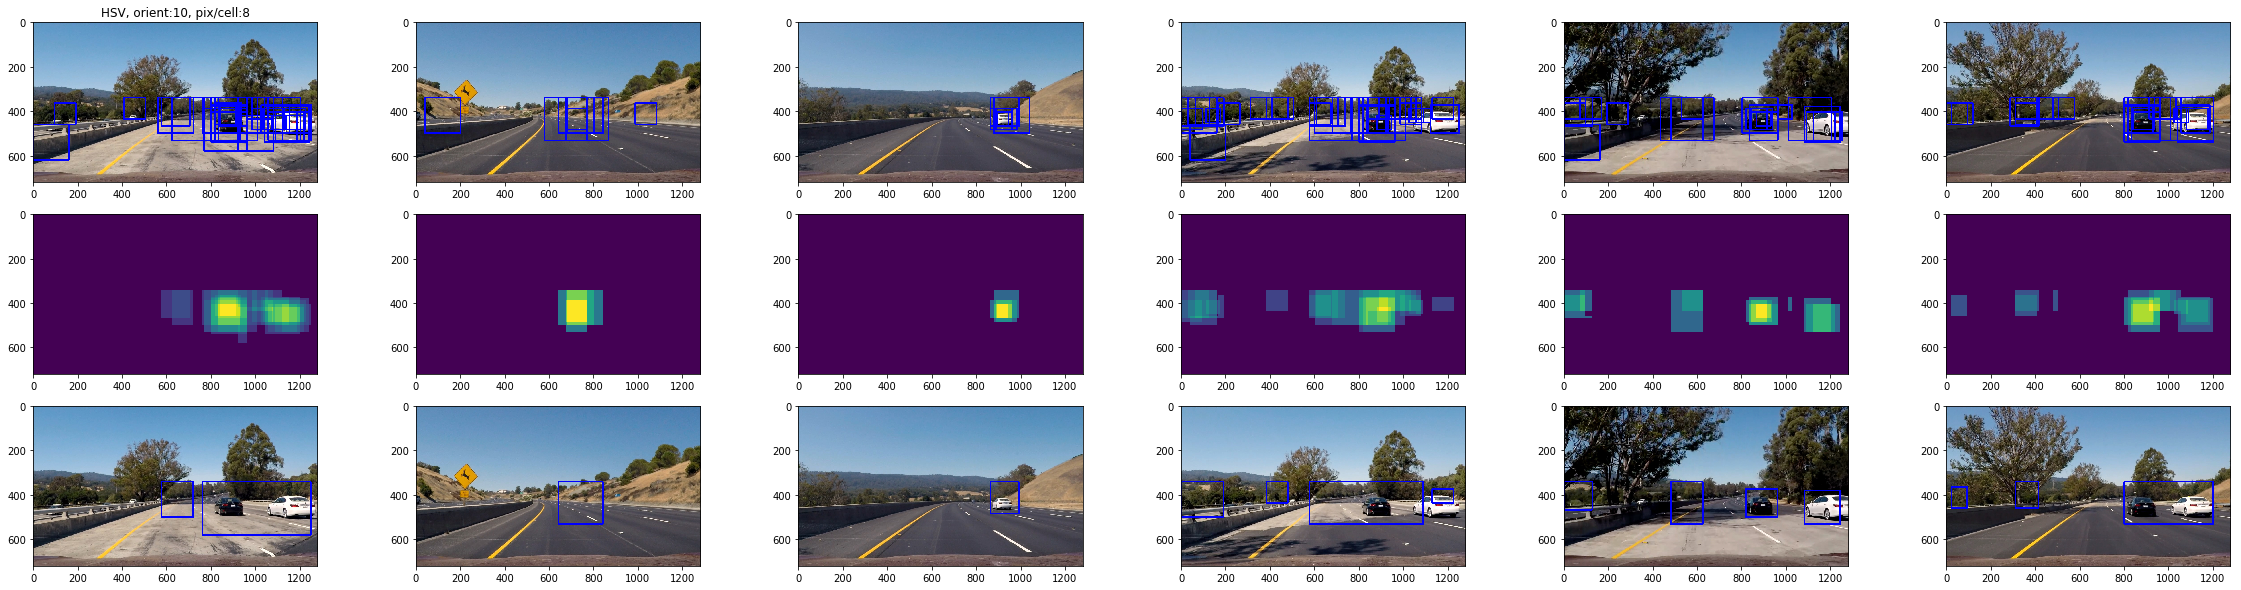

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


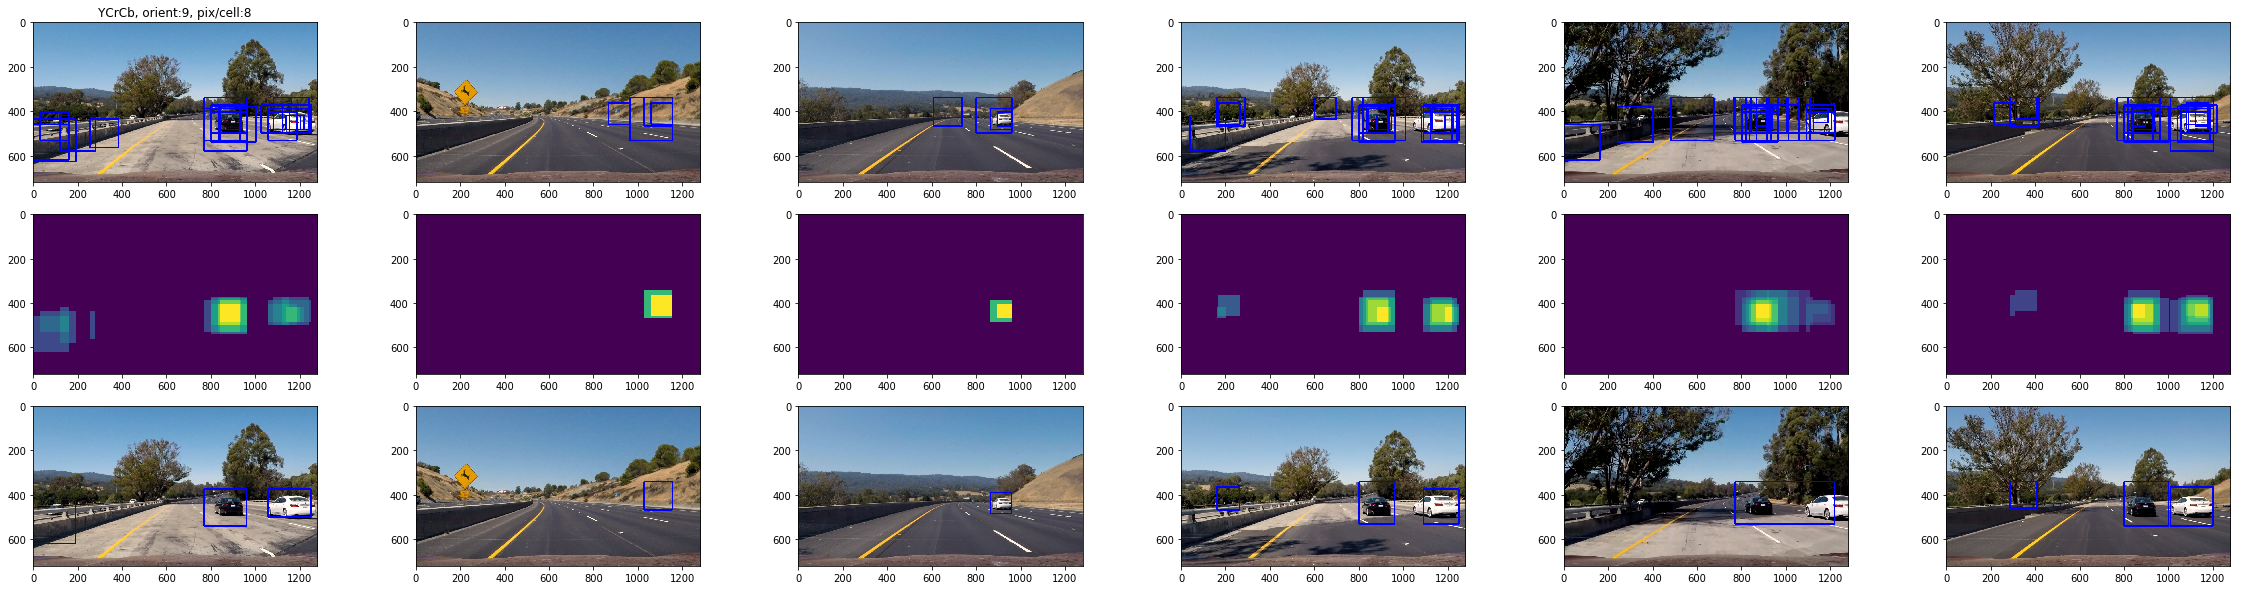

In [60]:
# Try the three models on test images
colorspace = ['HSV','YUV','YCrCb']
orient = [10,10,9]
pix_per_cell = [8, 16, 8]
cell_per_block = 2

scales=[1,1.5,2,2.5,3]
ystart = [340,340,340,340,340]
ystop = [500,525,600,675,719]

test_images = glob.glob('test_images/test*.jpg')

for m in range(3):
    svc = train_clf(colorspace[m], orient[m], pix_per_cell[m], cell_per_block, 'ALL')
    fig, ax = plt.subplots(3, len(test_images), figsize=(40, 10))
    ax = ax.ravel()
    i=0
    ax[i].set_title(colorspace[m]+", orient:"+str(orient[m])+", pix/cell:"+str(pix_per_cell[m]))
    for img_file in test_images:
        img = mpimg.imread(img_file)
        box_list=[]
        for j in range(len(scales)):
            out_img, b_list = find_cars(img, colorspace[m], ystart[j], ystop[j], scales[j], svc, orient[m], pix_per_cell[m], cell_per_block)
            box_list.extend(b_list)
            
        box_img = draw_boxes(np.copy(img), box_list)
        # Add heat to each box in box list
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat,box_list)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)

        ax[i].imshow(box_img)
        ax[i+len(test_images)].imshow(heatmap)
        ax[i+len(test_images)+len(test_images)].imshow(draw_img)
        i=i+1

In [47]:
colorspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
svc = train_clf(colorspace, orient, pix_per_cell, cell_per_block, 'ALL')

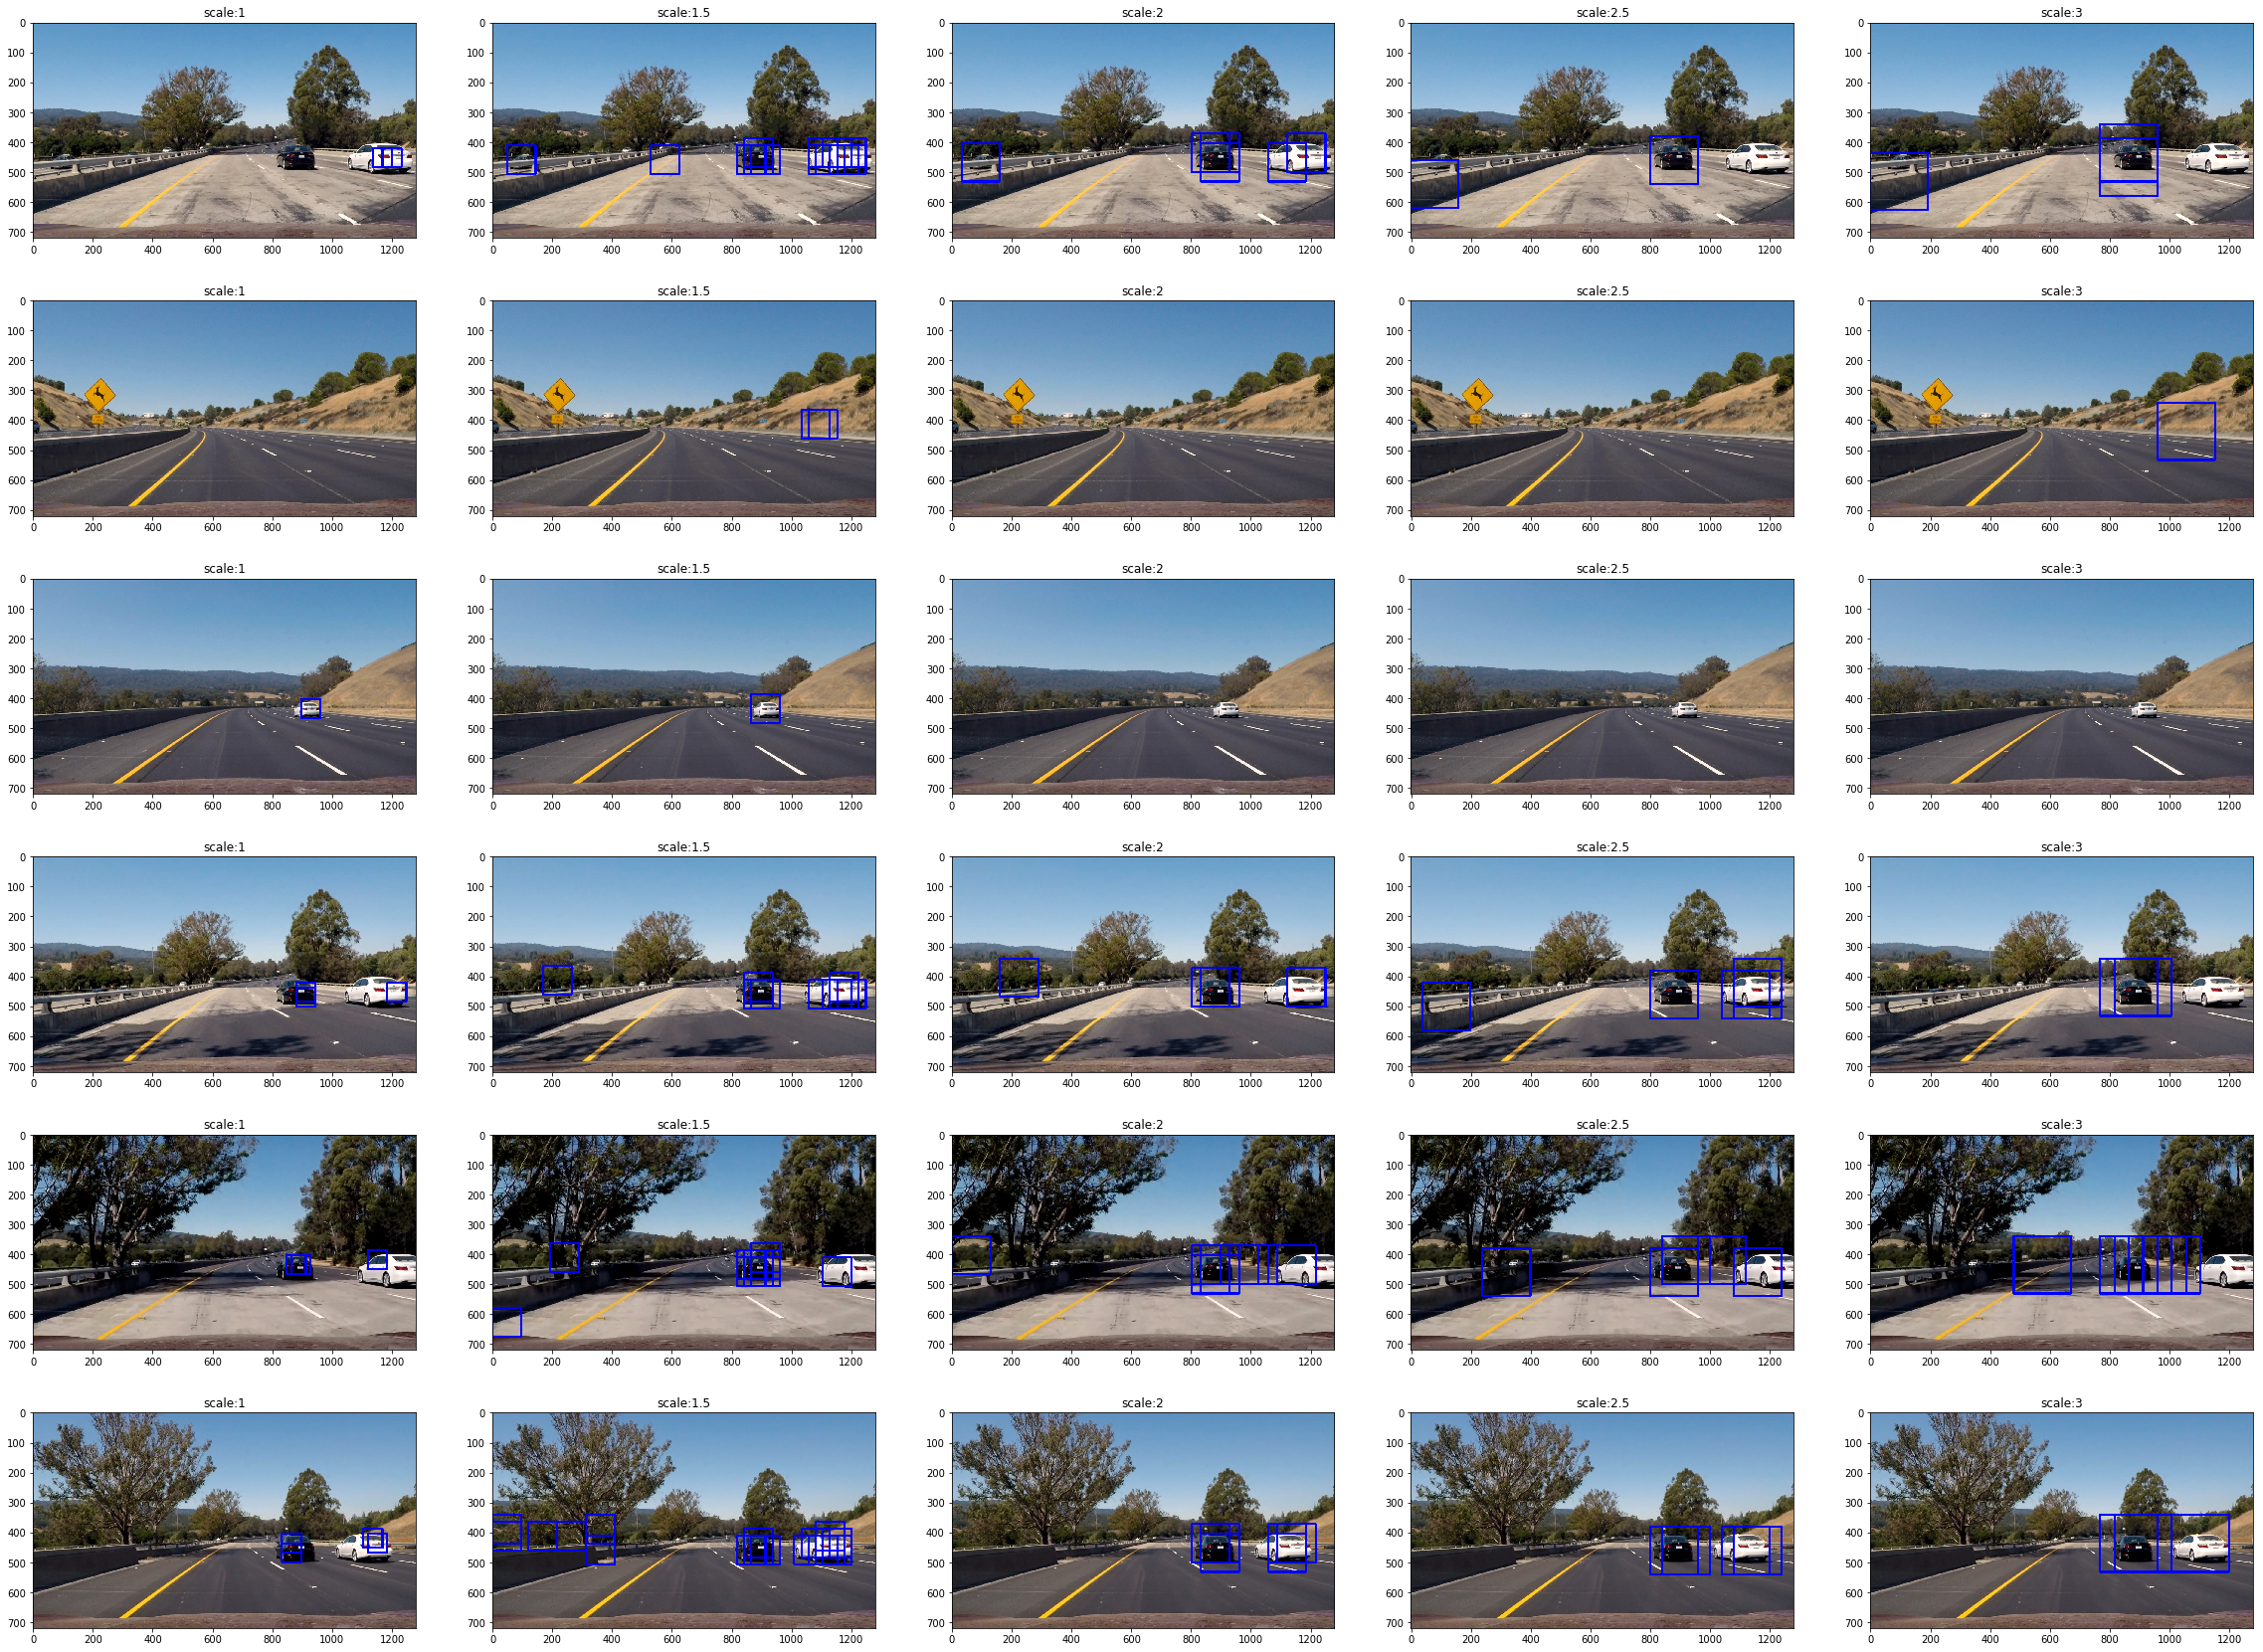

In [59]:
scales=[1,1.5,2,2.5,3]  
fig, ax = plt.subplots(len(test_images), len(scales), figsize=(40, 30))
ax = ax.ravel()
i=0
for img_file in test_images:
    img = mpimg.imread(img_file)
    height=img.shape[0]
    box_list=[]
    for j in range(len(scales)):
        out_img, b_list = find_cars(img, colorspace, 340, height-1, scales[j], svc, orient, pix_per_cell, cell_per_block)
        ax[i].imshow(out_img)
        ax[i].set_title("scale:"+str(scales[j]))
        i=i+1

In [ ]:
def process_image(img):
    box_list=[]
    for j in range(len(scales)):
        out_img, b_list = find_cars(img, colorspace, ystart[j], ystop[j], scales[j], svc, orient, pix_per_cell, cell_per_block)
        box_list.extend(b_list)
    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [52]:
from moviepy.editor import VideoFileClip
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(process_image)
video_output = 'output_images/project_output.mp4'
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_output.mp4
[MoviePy] Writing video output_images/project_output.mp4



 12%|█▏        | 152/1261 [01:00<07:07,  2.59it/s]


 24%|██▍       | 303/1261 [01:59<06:25,  2.48it/s]


 36%|███▌      | 454/1261 [03:01<05:17,  2.54it/s]


 48%|████▊     | 605/1261 [04:01<04:25,  2.47it/s]


 60%|█████▉    | 756/1261 [05:01<03:16,  2.57it/s]


 72%|███████▏  | 907/1261 [06:02<02:26,  2.41it/s]


 84%|████████▍ | 1057/1261 [07:03<01:19,  2.58it/s]


 96%|█████████▌| 1205/1261 [08:03<00:22,  2.46it/s]


100%|█████████▉| 1260/1261 [08:25<00:00,  2.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output.mp4 

CPU times: user 8min 4s, sys: 56.3 s, total: 9min
Wall time: 8min 26s


In [53]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [66]:
lastNFrames=[]
N=6
def lastN_image(img):
    global lastNFrames
    lastNFrames.append(img)
    if len(lastNFrames) > N:
                # throw out old fits, keep newest n
        lastNFrames = lastNFrames[len(lastNFrames)-N:]
        
    return img

In [67]:
from moviepy.editor import VideoFileClip
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(lastN_image)
video_output = 'output_images/project_output_tmp.mp4'
%time output_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video output_images/project_output_tmp.mp4
[MoviePy] Writing video output_images/project_output_tmp.mp4



100%|█████████▉| 1260/1261 [00:23<00:00, 54.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output_tmp.mp4 

CPU times: user 2.37 s, sys: 2.11 s, total: 4.49 s
Wall time: 23.8 s


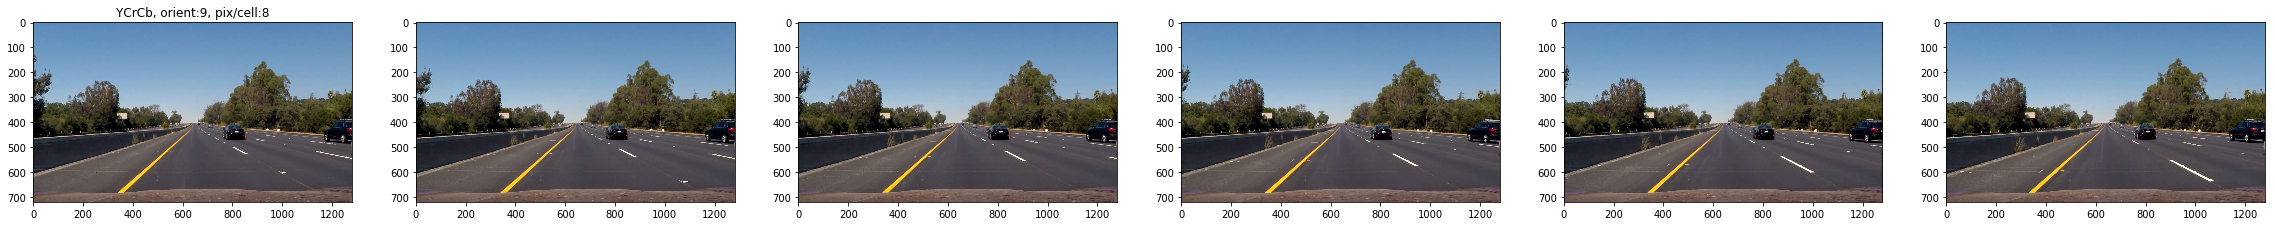

In [69]:
fig, ax = plt.subplots(1, len(lastNFrames), figsize=(40, 10))
ax = ax.ravel()
i=0
ax[i].set_title(colorspace[m]+", orient:"+str(orient[m])+", pix/cell:"+str(pix_per_cell[m]))
for img in lastNFrames:
    ax[i].imshow(img)
    i=i+1

UnboundLocalError: local variable 'feature_image' referenced before assignment

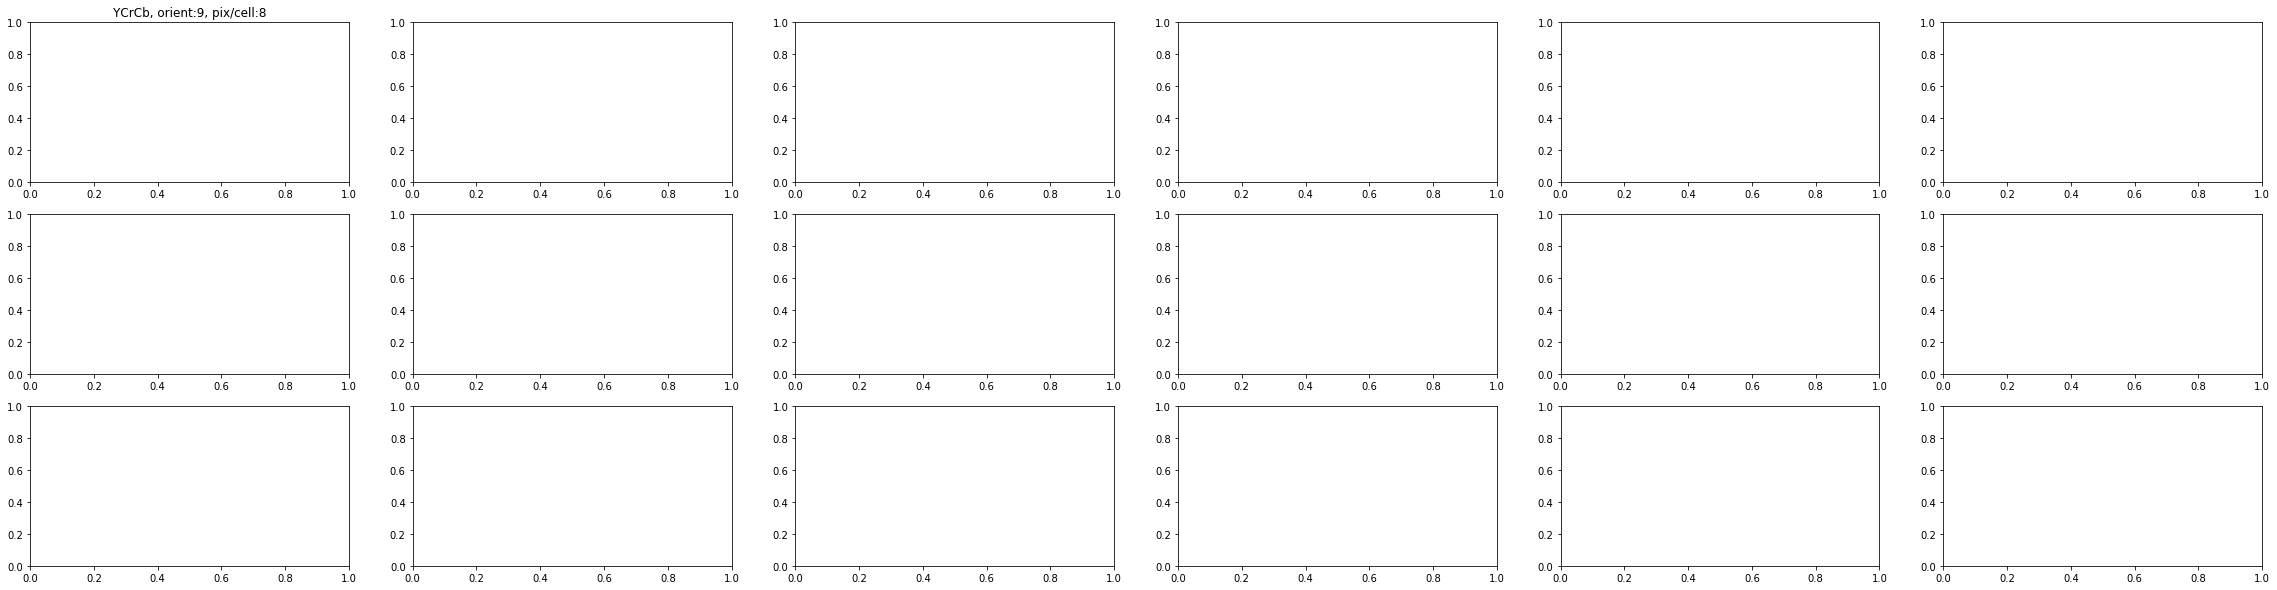

In [68]:
fig, ax = plt.subplots(3, len(lastNFrames), figsize=(40, 10))
ax = ax.ravel()
i=0
ax[i].set_title(colorspace[m]+", orient:"+str(orient[m])+", pix/cell:"+str(pix_per_cell[m]))
for img in lastNFrames:
    box_list=[]
    for j in range(len(scales)):
        out_img, b_list = find_cars(img, colorspace, ystart[j], ystop[j], scales[j], svc, orient, pix_per_cell, cell_per_block)
        box_list.extend(b_list)
            
    box_img = draw_boxes(np.copy(img), box_list)
    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    ax[i].imshow(box_img)
    ax[i+len(lastNFrames)].imshow(heatmap)
    ax[i+len(lastNFrames)+len(test_images)].imshow(draw_img)
    i=i+1